In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation
from scipy import signal as sn

In [161]:
freq = 81.5e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 500 * T
traces = 500
delta_t = 2e-7
N_time = int(max_time / delta_t)
# psd_stamps = int(N_time / 2 + 1)
t = np.linspace(0, max_time, int(N_time))
gamma = 13e3
gain1 = 1e5
gain2 = 2e5

In [122]:
env = Particle(omega, gamma, radius=73e-9)

In [123]:
print(max_time, (T/4)/delta_t, max_time/delta_t)
print('9.1GB RAM spent')
print('use smallest delta_t such that delay amount is appropriate')
print('commit between max_time and trace amount')

0.006134969325153374 15.337423312883436 30674.846625766873
9.1GB RAM spent
use smallest delta_t such that delay amount is appropriate
commit between max_time and trace amount


In [124]:
env.thermal_force_std

1973651.5163653938

In [125]:
cubic_delayed = {i: [None] for i in range(0, 62, 1)}
for key in cubic_delayed.keys():
    cubic = np.zeros(shape=(traces, N_time))
    for i in tqdm(range(traces)):
        data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain1*(env.zp_x**3/env.zp_p), key)
        data = np.array(data)
        cubic[i, :] = data
    cubic_delayed[key] = cubic

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 508.85it/s]


In [162]:
neg_cubic_delayed = {i: [None] for i in range(0,62,1)}
for key in neg_cubic_delayed.keys():
    cubic = np.zeros(shape=(traces, N_time))
    for i in tqdm(range(traces)):
        data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain2*(env.zp_x**3/env.zp_p), key)
        data = np.array(data)
        cubic[i, :] = data
    neg_cubic_delayed[key] = cubic

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 498.51it/s]


In [127]:
reference = np.zeros(shape=(traces, N_time))

for i in tqdm(range(traces)):
    data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, 0, 0)
    data = np.array(data)
    reference[i, :] = data

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 520.70it/s]


In [128]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]))
        if not np.isnan(pxx.max()) and not pxx.max()>1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs).mean(axis=0)

(73000.0, 90000.0)

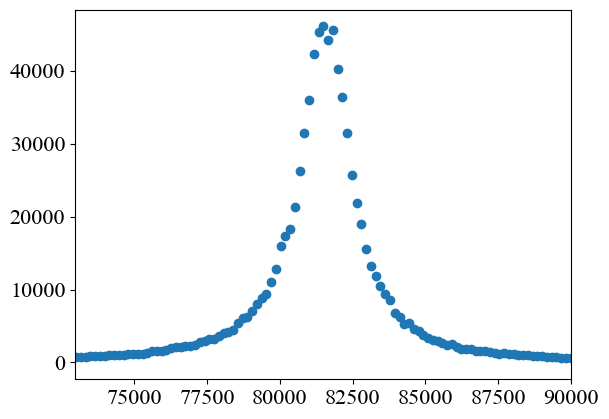

In [129]:
freq, pxx = psd(reference, delta_t)
plt.scatter(freq,pxx)
plt.xlim([7.3e4, 9e4])

In [163]:
ref_psd = psd(reference, delta_t)[1].sum()
delay_areas = []
neg_delay_areas = []
for key in list(cubic_delayed.keys()):
    freq, pxx = psd(cubic_delayed[key], delta_t)
    delay_areas.append(pxx.sum())
    if key == 40:
        freqp, pxxp = [freq, pxx]
    freq, pxx = psd(neg_cubic_delayed[key],delta_t)
    neg_delay_areas.append(pxx.sum())

delay_areas = np.array(delay_areas)
non_nan_indexes = ~np.isnan(np.array(delay_areas))
delay_areas = delay_areas[non_nan_indexes]
delays = np.array(list(cubic_delayed.keys()))[non_nan_indexes]*delta_t


neg_delay_areas = np.array(neg_delay_areas)
non_nan_indexes = ~np.isnan(np.array(neg_delay_areas))
neg_delay_areas = neg_delay_areas[non_nan_indexes]
neg_delays = np.array(list(neg_cubic_delayed.keys()))[non_nan_indexes]*delta_t


In [131]:
def autocor_0(t, omega, gamma, m= 3.368e-18):
    kb = 1.3806e-23
    T = 293
    C = 2*(gamma*kb*T/m)
    
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18):
    kb = 1.3806e-23
    T = 293
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -3*C*C*b*mult*(part1+part2+part3+part4)
    return T0+T1

def theoretical_area_frac(omega, gamma, gain, delay, m=3.368e-18):
    T0 = autocor_0(0, omega, gamma, m=m)
    T1 = autocor_perturbation(0, omega, gamma, gain, delay, m=m)
    return T1/T0

In [166]:
theory_delays = np.linspace(0, T, 100)
areas_1 = theoretical_area_frac(env.__omega__, env.__gamma__, -gain1/env._m_, theory_delays, m=env._m_)
areas_2 = theoretical_area_frac(env.__omega__, env.__gamma__, -gain2/env._m_, theory_delays, m=env._m_)

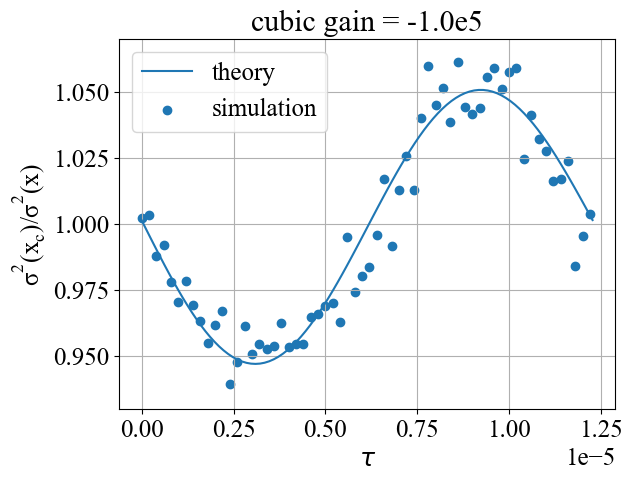

In [174]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.plot(theory_delays, areas_1)
#plt.plot(theory_delays, areas_2)
plt.scatter(delays, np.array(delay_areas)/ref_psd)
#plt.scatter(delays, np.array(neg_delay_areas)/ref_psd)
plt.legend(['theory','simulation'])#'gain = -{}e{}'.format(gain1/10**int(np.log10(gain1)),int(np.log10(gain1))),\
            #'gain = -{}e{}'.format(gain2/10**int(np.log10(gain2)),int(np.log10(gain2)))])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\mathdefault{\sigma ^{2} (x_{c})/\sigma ^{2} (x)}$')
plt.title('cubic gain = -1.0e5')
delta = 0.07
plt.ylim([1-delta,1+delta])
plt.grid()
plt.savefig('area_ratio_vs_delay.pdf', bbox_inches = 'tight')